## About the Task:

Guest Journey Patterns:
1. Use process mining or sequence analysis to identify common guest journey paths.
2. Compare these patterns across segments to uncover opportunities for personalization and operational improvements.


## About the Dataset

**Theme Park Attraction Visits Dataset**

Dataset Information:

This dataset comprises a set of users and their visits to various attractions in five theme parks (Disneyland, Epcot, California Adventure, Disney Hollywood and Magic Kindgom). The user-attraction visits are determined based on geo-tagged Flickr photos that are: (i) posted from Aug 2007 to Aug 2017 and retrieved using the Flickr API; (ii) then mapped to specific attraction location and attraction categories; and (iii) then grouped into individual travel sequences (consecutive user-attraction visits that differ by <8hrs). Other associated datasets are the "List of Attractions/POIs" dataset ("POI-{themeParkName}.csv" files from "poiList-sigir17.zip") and "Attraction/POI Cost-Profit Table" dataset ("costProfCat-{themeParkName}POI-all.csv" files from "costProf-sigir17.zip").

All user-attraction visits in each themepark are stored in a single csv file that contains the following columns/fields:

- id (photoID): identifier of the photo based on Flickr.

- nsid (userID): identifier of the user based on Flickr.

- dateTaken: the date/time that the photo was taken (unix timestamp format).

- poiID: identifier of the attraction (Flickr photos are mapped to attraction based on their lat/long).

- poiTheme: category of the attraction (e.g., Roller Coaster, Family, Water, etc).

- poiFreq: number of times this attraction has been visited.

- rideDuration: the normal ride duration of this attraction.

- seqID: travel sequence no. (consecutive attraction visits by the same user that differ by <8hrs are grouped as one travel sequence).

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# List files in your Google Drive
drive_path = "/content/drive/My Drive/Guest Journey Analysis/data"
os.listdir(drive_path)

['POI-disHolly.csv',
 'userVisits-disHolly-allPOI.csv',
 'userVisits-disland-allPOI.csv',
 'POI-caliAdv.csv',
 'userVisits-caliAdv-allPOI.csv',
 'data-sigir17.zip']

# Places of Interest

In [3]:
# Load the POI dataset
file_path = "/content/drive/My Drive/Guest Journey Analysis/data/POI-disHolly.csv"
poi = pd.read_csv(file_path, delimiter=";")

In [4]:
# View the poi dataset
import plotly.express as px

# Create interactive scatter plot with POI indexes
fig = px.scatter(
    poi,
    x="long",
    y="lat",
    hover_name="poiName",
    hover_data={"rideDuration": True, "theme": True, "long": False, "lat": False},
    color="theme",
    text=poi.index,  # Show POI index as text on points
    title="<b>Disney California Adventure Park Attractions</b>",
    labels={"long": "Longitude", "lat": "Latitude"},
    width=1000,
    height=700,
)

# Customize hover tooltip
fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color="DarkSlateGrey")),
    hovertemplate=(
        "<b>%{hovertext}</b><br>"
        "Duration: %{customdata[0]} min<br>"
        "Theme: %{customdata[1]}<br>"
        "<extra></extra>"
    ),
    textposition="top center",  # Position index labels
)

# Improve layout
fig.update_layout(
    plot_bgcolor="white",
    paper_bgcolor="white",
    title_font=dict(size=20),
    hoverlabel=dict(bgcolor="white", font_size=12),
    legend_title_text="<b>Theme</b>",
    xaxis=dict(showgrid=True, gridcolor="lightgray"),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
)

# Add a small buffer to axis limits
fig.update_xaxes(range=[poi["long"].min() - 0.002, poi["long"].max() + 0.002])
fig.update_yaxes(range=[poi["lat"].min() - 0.001, poi["lat"].max() + 0.001])

# Show the plot
fig.show()


In [5]:
# Load the dataset
file_path = "/content/drive/My Drive/Guest Journey Analysis/data/userVisits-disHolly-allPOI.csv"
df = pd.read_csv(file_path, delimiter=";")

# Check the first few rows
df.head()

,id,nsid,takenUnix,poiID,poiTheme,poiFreq,rideDuration,seqID
0,4617275371,10005149@N03,1274095158,5,Roller Coaster,2616,900,1
1,8235744245,10008488@N07,1354345925,6,Ride,5969,1020,2
2,8236810104,10008488@N07,1354346676,6,Ride,5969,1020,2
3,9513896740,100320969@N08,1375140897,2,Ride,2936,390,3
4,9511104781,100320969@N08,1375140906,2,Ride,2936,390,3


We have 1972 distinct users for this dataset.

In [6]:
df["nsid"].nunique()

1972

In [7]:
df["id"].nunique()

41983

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41983 entries, 0 to 41982
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            41983 non-null  int64 
 1   nsid          41983 non-null  object
 2   takenUnix     41983 non-null  int64 
 3   poiID         41983 non-null  int64 
 4   poiTheme      41983 non-null  object
 5   poiFreq       41983 non-null  int64 
 6   rideDuration  41983 non-null  int64 
 7   seqID         41983 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 2.6+ MB


## Data Preprocessing

In [9]:
# Convert UNIX timestamp to datetime
df["takenUnix"] = pd.to_datetime(df["takenUnix"], unit="s")

# Rename column for clarity
df.rename(columns={"takenUnix": "dateTaken"}, inplace=True)

# Sort the data
df = df.sort_values(by=["id", "dateTaken"])

# Display first few rows
df.head()

,id,nsid,dateTaken,poiID,poiTheme,poiFreq,rideDuration,seqID
2002,1227085805,11632646@N02,2007-08-24 09:51:04,6,Ride,5969,1020,195
940,1323713653,10905622@N03,2007-09-04 04:53:54,1,Roller Coaster,5825,90,106
1637,1343441367,11438118@N00,2007-09-06 02:39:34,5,Roller Coaster,2616,900,170
1638,1343446737,11438118@N00,2007-09-06 02:43:11,5,Roller Coaster,2616,900,170
1639,1343664239,11438118@N00,2007-09-06 03:38:55,1,Roller Coaster,5825,90,170


In [10]:
# Drop any missing values
df = df.dropna()

# Check if there are duplicate entries
df.duplicated().sum()

np.int64(0)

# Prepare temporal features
Rationale for temporal analysis:  If opportunity zones consistently receive fewer photos across all seasons and years, it suggests structural factors rather than seasonal variation.

In [11]:
from geopy.distance import great_circle

#convert poiID in df to integer
df['poiID'] = df['poiID'].astype(int)

# Merge photos_df with poi_df on 'poiID'
merged_df = df.merge(poi[['poiID', 'poiName', 'lat', 'long']], on='poiID', how='left')

# Display the first few rows
print(merged_df.head())

           id          nsid           dateTaken  poiID        poiTheme  \
0  1227085805  11632646@N02 2007-08-24 09:51:04      6            Ride   
1  1323713653  10905622@N03 2007-09-04 04:53:54      1  Roller Coaster   
2  1343441367  11438118@N00 2007-09-06 02:39:34      5  Roller Coaster   
3  1343446737  11438118@N00 2007-09-06 02:43:11      5  Roller Coaster   
4  1343664239  11438118@N00 2007-09-06 03:38:55      1  Roller Coaster   

   poiFreq  rideDuration  seqID                            poiName        lat  \
0     5969          1020    195                   Muppet*Vision 3D  28.354907   
1     5825            90    106            Rock 'n' Roller Coaster  28.357837   
2     2616           900    170  The Twilight Zone Tower of Terror  28.360014   
3     2616           900    170  The Twilight Zone Tower of Terror  28.360014   
4     5825            90    170            Rock 'n' Roller Coaster  28.357837   

        long  
0 -81.559527  
1 -81.560349  
2 -81.559949  
3 -81.55

<Figure size 1200x600 with 0 Axes>

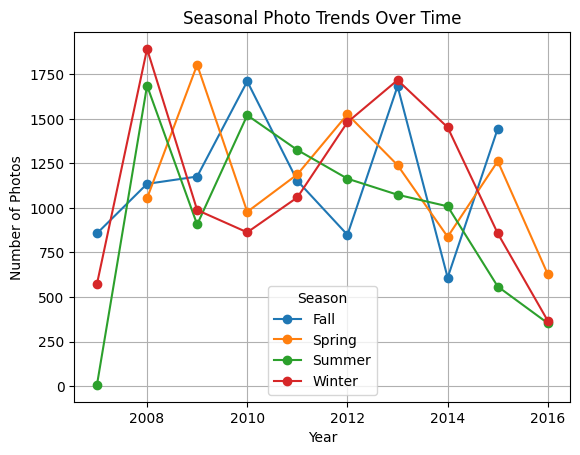

In [12]:
# Extract temporal features
df['year'] = df['dateTaken'].dt.year
df['month'] = df['dateTaken'].dt.month

# Define seasons (adjust as needed)
season_mapping = {12: "Winter", 1: "Winter", 2: "Winter",
                  3: "Spring", 4: "Spring", 5: "Spring",
                  6: "Summer", 7: "Summer", 8: "Summer",
                  9: "Fall", 10: "Fall", 11: "Fall"}

df['season'] = df['month'].map(season_mapping)

# Count photos per season over the years
seasonal_trends = df.groupby(['year', 'season']).size().unstack()

# Plot seasonal trends
plt.figure(figsize=(12, 6))
seasonal_trends.plot(marker='o')
plt.title('Seasonal Photo Trends Over Time')
plt.ylabel('Number of Photos')
plt.xlabel('Year')
plt.legend(title="Season")
plt.grid(True)
plt.show()


<Figure size 1200x600 with 0 Axes>

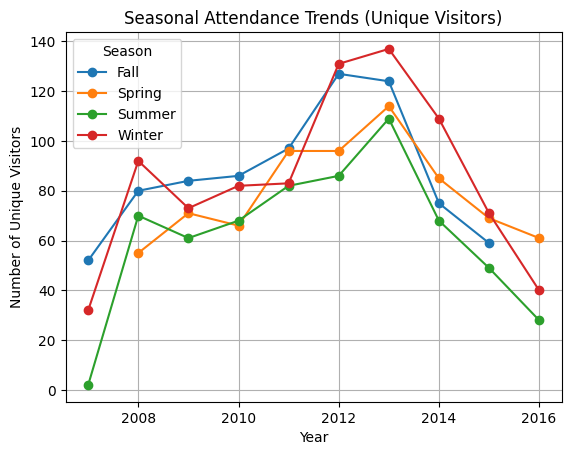

In [13]:
# Count unique users per season over the years
unique_visitors = df.groupby(['year', 'season'])['nsid'].nunique().unstack()

# Plot unique visitors trends
plt.figure(figsize=(12, 6))
unique_visitors.plot(marker='o')
plt.title('Seasonal Attendance Trends (Unique Visitors)')
plt.ylabel('Number of Unique Visitors')
plt.xlabel('Year')
plt.legend(title="Season")
plt.grid(True)
plt.show()

## Identify Guest Journey Sequences

In [22]:
#! pip install pm4py
import pm4py
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import networkx as nx

In [15]:
# Ensure proper data types
df['dateTaken'] = pd.to_datetime(df['dateTaken'])  # Convert to datetime
df['poiID'] = df['poiID'].astype(str)  # Convert IDs to strings to avoid comparison issues

# Convert the dataframe to an event log format for process mining
event_log = df.copy()

# Sort the data by user and timestamp
event_log = event_log.sort_values(['nsid', 'dateTaken'])

# Create the required columns with proper formats
event_log_pm4py = pd.DataFrame({
    'case:concept:name': event_log['nsid'].astype(str),
    'concept:name': event_log['poiID'].astype(str),
    'time:timestamp': event_log['dateTaken']
})

# Convert to PM4Py event log format
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

event_log_pm4py = dataframe_utils.convert_timestamp_columns_in_df(event_log_pm4py)
log = log_converter.apply(event_log_pm4py)


## Visualising Guest Journey Patterns

### NetworkX



Most common multi-attraction journey patterns:
Frequency: 55, Pattern: 6 → 6
Frequency: 42, Pattern: 1 → 1
Frequency: 29, Pattern: 8 → 8
Frequency: 26, Pattern: 4 → 4
Frequency: 26, Pattern: 8 → 8 → 8


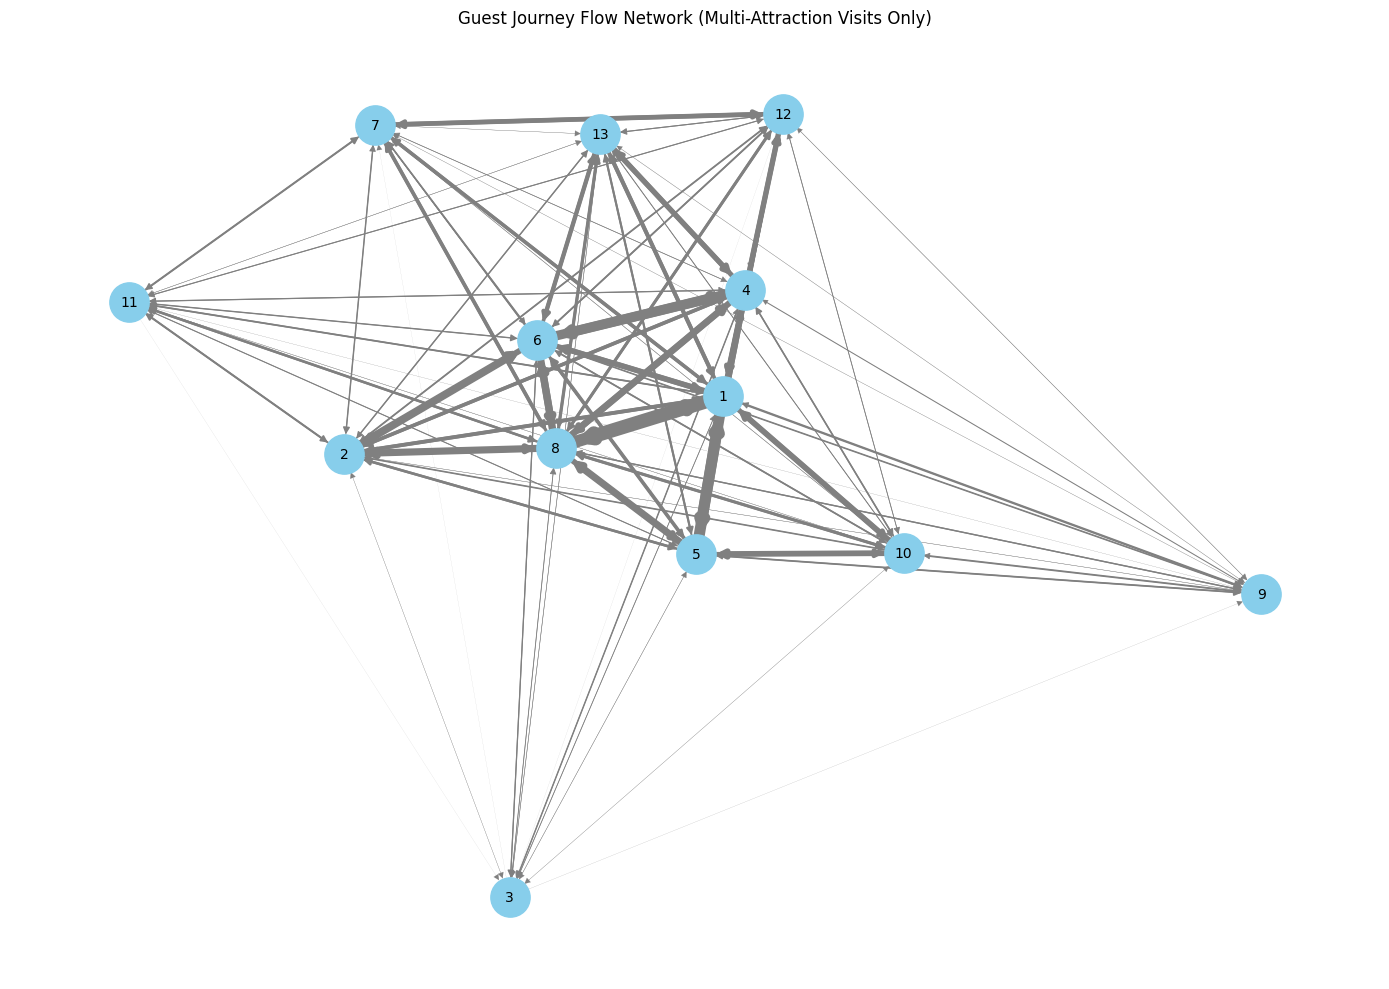


Top transitions for Ride:
  1. 8 → 6 (frequency: 197)
  2. 6 → 8 (frequency: 175)
  3. 8 → 2 (frequency: 152)
  4. 2 → 6 (frequency: 143)
  5. 2 → 8 (frequency: 126)

Top transitions for Roller Coaster:
  1. 1 → 5 (frequency: 257)
  2. 5 → 1 (frequency: 246)

Top transitions for Family:
  1. 7 → 12 (frequency: 82)
  2. 12 → 7 (frequency: 69)
  3. 10 → 13 (frequency: 56)
  4. 10 → 9 (frequency: 45)
  5. 11 → 7 (frequency: 39)


In [16]:
# Group attractions by visitor (nsid) and visit sequence (seqID)
visitor_journeys = {}
for visitor, visitor_data in df.groupby('nsid'):
    # Sort by dateTaken to get chronological order
    visitor_data = visitor_data.sort_values('dateTaken')

    # Group by seqID to separate different park visits
    for seq_id, seq_data in visitor_data.groupby('seqID'):
        journey_key = f"{visitor}_{seq_id}"
        visitor_journeys[journey_key] = list(seq_data['poiID'].astype(str))

# Count journey patterns (attraction sequences) - ONLY KEEP THOSE WITH >1 ATTRACTION
journey_patterns = {}
for journey in visitor_journeys.values():
    if len(journey) < 2:  # Skip single-attraction visits
        continue
    journey_str = ' → '.join(journey)
    journey_patterns[journey_str] = journey_patterns.get(journey_str, 0) + 1

# Show most common journey patterns (only multi-attraction)
print("\nMost common multi-attraction journey patterns:")
for pattern, count in sorted(journey_patterns.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Frequency: {count}, Pattern: {pattern}")

# Create transition graph (showing how guests move between attractions)
transitions = {}
for journey in visitor_journeys.values():
    if len(journey) < 2:
        continue
    for i in range(len(journey) - 1):
        source = journey[i]
        target = journey[i+1]
        if source != target:  # Only add if attractions are different
            transition = (source, target)
            transitions[transition] = transitions.get(transition, 0) + 1

# Create directed graph of transitions
G = nx.DiGraph()
for (source, target), weight in transitions.items():
    G.add_edge(source, target, weight=weight)

# Visualize the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)  # Fixed seed for reproducibility
edge_weights = [G[u][v]['weight']/max(transitions.values())*10 for u, v in G.edges()]

nx.draw_networkx(G, pos,
                node_color='skyblue',
                node_size=800,
                font_size=10,
                width=edge_weights,
                edge_color='gray',
                with_labels=True,
                arrows=True)
plt.title('Guest Journey Flow Network (Multi-Attraction Visits Only)')
plt.axis('off')
plt.tight_layout()
plt.show()

# Analyze journeys by theme (multi-attraction sequences)
theme_transitions = {}
for theme in df['poiTheme'].unique():
    theme_df = df[df['poiTheme'] == theme]
    theme_transitions[theme] = {}

    for visitor, visitor_data in theme_df.groupby('nsid'):
        visitor_data = visitor_data.sort_values('dateTaken')
        for seq_id, seq_data in visitor_data.groupby('seqID'):
            journey = list(seq_data['poiID'].astype(str))
            if len(journey) < 2:
                continue
            for i in range(len(journey) - 1):
                source = journey[i]
                target = journey[i+1]
                if source != target:  # Only add if attractions are different
                    transition = (source, target)
                    if transition not in theme_transitions[theme]:
                        theme_transitions[theme][transition] = 0
                    theme_transitions[theme][transition] += 1

# Show top transitions for each theme (only multi-attraction)
for theme, transitions in theme_transitions.items():
    if transitions:
        print(f"\nTop transitions for {theme}:")
        sorted_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)
        for i, ((source, target), count) in enumerate(sorted_transitions[:5]):
            print(f"  {i+1}. {source} → {target} (frequency: {count})")

We now combine the Sequence dataset to the Places of Interest dataset to conduct analysis with location coordinates.

In [17]:
merged_df.head()

,id,nsid,dateTaken,poiID,poiTheme,poiFreq,rideDuration,seqID,poiName,lat,long
0,1227085805,11632646@N02,2007-08-24 09:51:04,6,Ride,5969,1020,195,Muppet*Vision 3D,28.354907,-81.559527
1,1323713653,10905622@N03,2007-09-04 04:53:54,1,Roller Coaster,5825,90,106,Rock 'n' Roller Coaster,28.357837,-81.560349
2,1343441367,11438118@N00,2007-09-06 02:39:34,5,Roller Coaster,2616,900,170,The Twilight Zone Tower of Terror,28.360014,-81.559949
3,1343446737,11438118@N00,2007-09-06 02:43:11,5,Roller Coaster,2616,900,170,The Twilight Zone Tower of Terror,28.360014,-81.559949
4,1343664239,11438118@N00,2007-09-06 03:38:55,1,Roller Coaster,5825,90,170,Rock 'n' Roller Coaster,28.357837,-81.560349


# Opportunity Zone Analysis

A key way to manage congestion is to strategically disperse key attractions across the park which my teammate has developed a model for under subquestion B2: Optimization of Attraction Layouts and Schedules.

However, it is key to note that other attractions nearby to these hotspots should serve as a strong complement, rather than being neglected/ redundant.

They should help guests experience more once they have arrived in the vicinity of the hot spots, effectively reducing walking time and enhancing experience, increasing guest satisfaction.

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Load your dataframe
plot_df = merged_df.copy()

# 1. Identify top attractions
top_attractions = plot_df['poiName'].value_counts().head(5).index.tolist()

# 2. Get exact coordinates of top attractions
top_coords = []
for attraction in top_attractions:
    attraction_coords = plot_df[plot_df['poiName'] == attraction][['lat', 'long']].iloc[0]
    top_coords.append((attraction_coords['lat'], attraction_coords['long']))

# 3. Mark whether each photo is at a top attraction location
plot_df['is_top_attraction'] = plot_df.apply(
    lambda row: (row['lat'], row['long']) in top_coords,
    axis=1
)

# 4. Calculate distance to nearest top attraction
def min_distance_to_top(row, top_coords):
    photo_coord = (row['lat'], row['long'])
    distances = [geodesic(photo_coord, top_coord).meters for top_coord in top_coords]
    return min(distances) if distances else np.nan

plot_df['distance_to_top'] = plot_df.apply(
    lambda row: min_distance_to_top(row, top_coords),
    axis=1
)


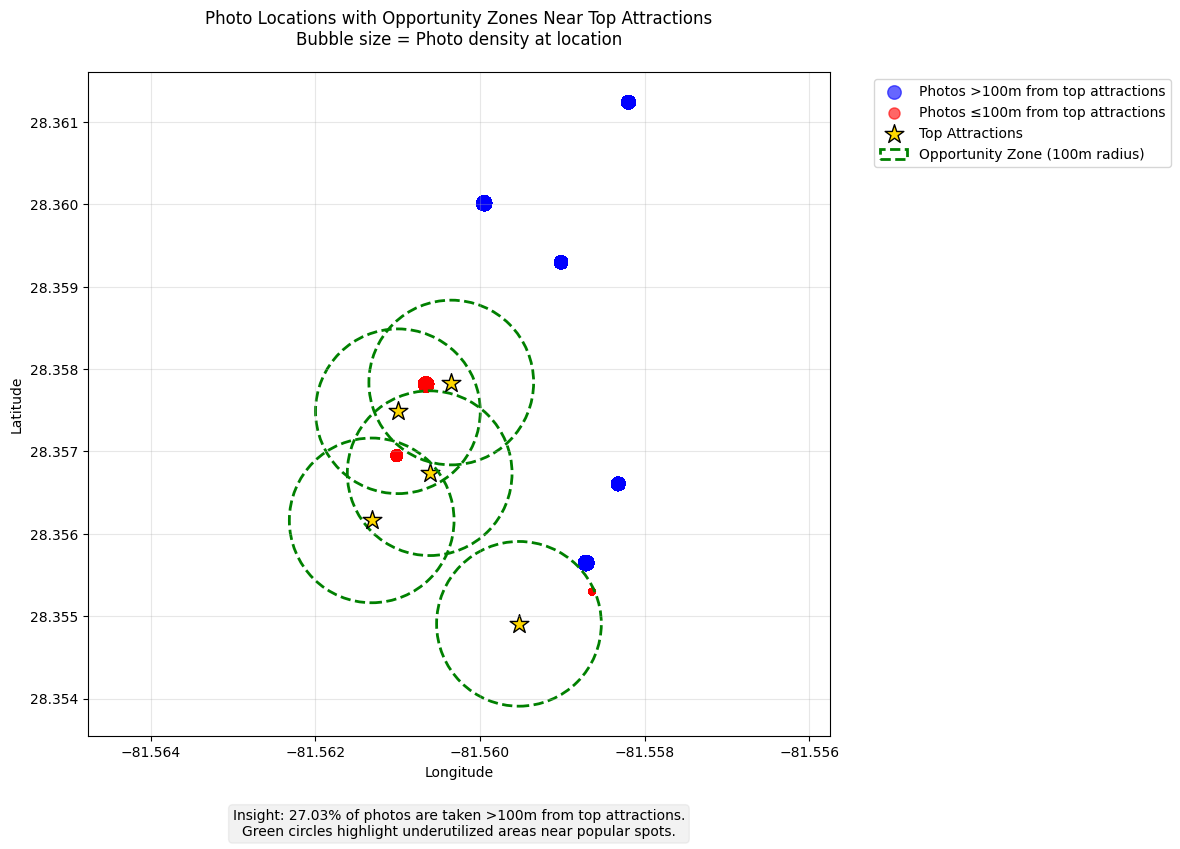

In [28]:
# 5. Categorize photos
plot_df['category'] = np.where(
    plot_df['distance_to_top'] <= 100,
    'Near top attraction (<100m)',
    'Far from top attraction (>100m)'
)

# 6. Calculate photo density (count at each unique coordinate)
# Use suffixes or rename columns to avoid merge conflict
coord_density = plot_df.groupby(['lat', 'long']).size().reset_index(name='coord_density')  # Changed name
plot_df = plot_df.merge(coord_density, on=['lat', 'long'])

# 7. Calculate the percentage of photos >100m from top attractions
far_percentage = (len(plot_df[plot_df['category'] == 'Far from top attraction (>100m)']) / len(plot_df)) * 100
far_percentage_rounded = round(far_percentage, 2)

# 8. Create the plot with density-based bubbles
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.set_aspect('equal', adjustable='datalim')  # For proper circles

# Main title with subtitle
plt.title(
    'Photo Locations with Opportunity Zones Near Top Attractions\n'
    'Bubble size = Photo density at location',
    pad=20
)

# A. Plot photos far from top attractions (>100m)
far_df = plot_df[plot_df['category'] == 'Far from top attraction (>100m)']
plt.scatter(
    x=far_df['long'],
    y=far_df['lat'],
    s=10 + 100 * (far_df['coord_density'] / far_df['coord_density'].max()),  # Use new column name
    c='blue',
    alpha=0.6,
    label='Photos >100m from top attractions'
)

# B. Plot photos near top attractions (≤100m) - excluding top attractions themselves
near_df = plot_df[
    (plot_df['category'] == 'Near top attraction (<100m)') &
    (~plot_df['is_top_attraction'])
]
plt.scatter(
    x=near_df['long'],
    y=near_df['lat'],
    s=10 + 100 * (near_df['coord_density'] / near_df['coord_density'].max()),  # Use new column name
    c='red',
    alpha=0.6,
    label='Photos ≤100m from top attractions'
)

# C. Highlight top attractions (gold stars)
for i, (lat, lon) in enumerate(top_coords):
    plt.scatter(
        lon, lat,
        c='gold',
        s=200,
        marker='*',
        edgecolors='black',
        label='Top Attractions' if i == 0 else None
    )
    # Draw opportunity zone circles
    ax.add_patch(plt.Circle(
        (lon, lat),
        0.001,  # Approx 100m in degrees
        color='green',
        fill=False,
        linestyle='--',
        linewidth=2,
        label='Opportunity Zone (100m radius)' if i == 0 else None
    ))

# Add legend and labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add insight annotation with dynamic percentage
plt.annotate(
    f"Insight: {far_percentage_rounded}% of photos are taken >100m from top attractions.\n"
    "Green circles highlight underutilized areas near popular spots.",
    xy=(0.5, -0.15),
    xycoords='axes fraction',
    ha='center',
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.1, color="gray")
)

plt.show()

In [26]:
from scipy.spatial import KDTree
from geopy.distance import great_circle

# Define high-traffic areas (top 10% most photographed locations)
top_locations = merged_df['poiID'].value_counts().nlargest(int(0.1 * len(merged_df['poiID'].unique()))).index
high_traffic_df = merged_df[merged_df['poiID'].isin(top_locations)][['lat', 'long']].drop_duplicates()

# Build a KDTree for high-traffic locations
high_traffic_tree = KDTree(high_traffic_df[['lat', 'long']].values)

# Query all locations in merged_df to check if they are within 100m
merged_df_coords = merged_df[['lat', 'long']].values
distances, _ = high_traffic_tree.query(merged_df_coords, distance_upper_bound=0.0009)  # Approx. 100m in degrees

# Assign a boolean flag if within 100m of a high-traffic area
merged_df['near_high_traffic'] = (distances != np.inf) & (~merged_df['poiID'].isin(top_locations))

# Compare photo counts
photo_counts = merged_df.groupby('near_high_traffic')['id'].count()
photo_percentage = (photo_counts / photo_counts.sum()) * 100

print("Photo distribution near high-traffic areas:")
print(photo_percentage)


Photo distribution near high-traffic areas:
near_high_traffic
False    88.535836
True     11.464164
Name: id, dtype: float64


In [21]:
# Count photos per location
photo_counts = merged_df.groupby(['poiID', 'poiName', 'lat', 'long']).size().reset_index(name='photo_count')

# Keep only locations near high-traffic areas but not high-traffic themselves
photo_counts = photo_counts[photo_counts['poiID'].isin(merged_df.loc[merged_df['near_high_traffic'], 'poiID'])]

# Filter for opportunity zones: locations with lower-than-median photo counts
median_photo_count = photo_counts['photo_count'].median()
opportunity_zones = photo_counts[photo_counts['photo_count'] < median_photo_count]

# Sort by least photographed
opportunity_zones = opportunity_zones.sort_values(by='photo_count', ascending=True)

print(opportunity_zones[['poiID', 'poiName', 'photo_count']].head(10))  # Top 10 least photographed locations


    poiID                       poiName  photo_count
10     11  Walt Disney: One Man's Dream         1152
